## Connect to Google drive

Here, we use the code learnt from our labs to connect to our google drive enviornment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To import the OSMnx library, we first have to use pip install to retrieve the library. Code retrieved from: https://stackoverflow.com/questions/59647101/osmnx-in-google-colab

In [ ]:
!apt-get -qq install -y libspatialindex-dev && pip install -q -U osmnx

Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-c6:amd64.
Preparing to unpack .../libspatialindex-c6_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-c6:amd64 (1.9.3-2) ...
Selecting previously unselected package libspatialindex-dev:amd64.
Preparing to unpack .../libspatialindex-dev_1.9.3-2_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.9.3-2) ...
Setting up libspatialindex6:amd64 (1.9.3-2) ...
Setting up libspatialindex-c6:amd64 (1.9.3-2) ...
Setting up libspatialindex-dev:amd64 (1.9.3-2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/l

To colour the output text of our Q Table, we pip installed colorama so that postive values were set to green and negative values were set to red.
Retrieved from: https://pypi.org/project/colorama/

In [ ]:
pip install colorama

This code was essential for creating animations in our local .py file. However, due to limitations in Google Colab that make it challenging to display these animations seamlessly, it is redundant here.

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

## Import Libraries

Before creating our stochastic environment and Q-learning agent, we need to import all the necessary Python libraries. The key one here is the OSMnx library, which will be used to create our Manhattan map using OpenStreetMap data.

In [ ]:
import math
import random
from collections import defaultdict
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FFMpegWriter
matplotlib.rcParams['animation.ffmpeg_path'] = r'path\to\ffmpeg.exe'
import pandas as pd
from colorama import Fore
import numpy as np
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation

## Generate Map from long-lat coordinates

In this section, we utilize the OSMnx library to generate our stochastic environment. The variables `north`, `south`, `east`, and `west` represent the edges of the bounding box of Manhattan. We initially obtained the approximate values of 40.7831° N and 73.9712° W using Google Maps. From these coordinates, we gradually narrowed our margins until an appropriately sized graph was produced.


In [ ]:
# Source for OSMnx implementation: Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing,
# and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139.
# Retrieved From: https://geoffboeing.com/publications/osmnx-complex-street-networks/

class genMap:
    def __init__(self) -> None:
        # Define a threshold for degree centrality
        # self.degree_threshold = 1
        self.genMap()
        self.createNodes()

    def genMap(self):
        # Define the bounding box for Manhattan Island (latitude and longitude coordinates)
        north, south, east, west = 40.7030, 40.7010, -74.0174, -74.0150

        # Retrieve the street network data for Manhattan
        graph = ox.graph_from_bbox(north, south, east, west, network_type='all')

        # Calculate degree centrality for each node (how many neighbors a node has)
        node_degrees = dict(nx.degree(graph))

        # Filter major intersections based on degree centrality
        major_intersections = [node for node, degree in node_degrees.items() if degree >= self.degree_threshold]

        self.major_intersections_graph = graph.subgraph(major_intersections)

        # Get the x and y coordinates of each node
        self.node_x = {node: data['x'] for node, data in self.major_intersections_graph.nodes(data=True)}
        self.node_y = {node: data['y'] for node, data in self.major_intersections_graph.nodes(data=True)}

        # Calculate the length of connecting nodes
        self.edge_lengths = {}
        for u, v, data in self.major_intersections_graph.edges(data=True):
            length = data.get('length')
            if length is not None:
                self.edge_lengths[(u, v)] = length

        # Output node coordinates and edge lengths

    def createNodes(self):
        self.map = Map()

        # Create a hashmap of connecting nodes
        graph_dict = {}
        for u, v, k, data in self.major_intersections_graph.edges(keys=True, data=True):
            if u not in graph_dict:
                graph_dict[u] = {}
            graph_dict[u][v] = data['length']

        filtered_nodes = set(graph_dict.keys())  # Get all the nodes that are connected to other nodes

        filtered_edges = {k: v for k, v in self.edge_lengths.items() if
                          k[0] in filtered_nodes and k[1] in filtered_nodes}

        self.map.addNodes(filtered_nodes, self.node_x, self.node_y, filtered_edges)

    def returnMap(self):
        return self.map


## Map Class

In this section, we create the `Map` class, which consists of two main parts. One part is dedicated to the logical structure of the code, and the other focuses on the animation of the graph (as demonstrated in our video). The `Map` class has hardcoded values for the start and end (terminal) nodes of our stochastic environment.

To calculate the distance between nodes and between a node and the terminal node, the Euclidean distance formula was implemented and is shown below:

$$d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

The `addNodes` function is used to iterate through each node in the generated map and add them to its own node list. We set the number of tourist sites in our environment to be 20, which are randomly allocated to nodes in this list.

The `plotGraph` function uses Matplotlib to depict our stochastic environment as a graph for easier visualization.

**Note:** The animations for the graph did not work in the Google Colab environment.

Source: https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb#scrollTo=ed-DqATbH55Y


In [ ]:
class Map:
    def __init__(self):
        self.endNode = None
        self.startNode = None
        self.nodeList = {}
        self.terminalPaths = []
        self.terminalNodes = []
        self.startId = 11016696064
        self.endId = 1494150071
        self.sites = []

    def getNodes(self):
        return self.nodeList

    def getNode(self, ID):
        for node in self.nodeList.keys():
            if node == ID:
                return self.nodeList[node]

    def calcDistToTerminal(self, node):
        node_x, node_y = node.getCoordinates()
        final_node_x, final_node_y = self.endNode.getCoordinates()
        return math.sqrt((final_node_x - node_x) ** 2 + (final_node_y - node_y) ** 2)

    def calcDist(self, node1, node2):
        node1_x, node1_y = node1.getCoordinates()
        node2_x, node2_y = node2.getCoordinates()
        return math.sqrt((node2_x - node1_x) ** 2 + (node2_y - node1_y) ** 2)

    # Takes in a hashmap of all connecting nodes
    def addNodes(self, nodes, xCords, yCords, paths):

        for id in nodes:
            # Create Nodes
            newNode = Node(id, xCords[id], yCords[id])
            self.nodeList[id] = newNode
            if newNode.id == self.startId:
                self.startNode = newNode

            if newNode.id == self.endId:
                self.endNode = newNode
                self.terminalNodes.append(newNode)

        num_sites = 20
        random_nodes = random.sample(self.nodeList.items(), num_sites)
        for nodeID, node in random_nodes:
            self.nodeList[nodeID].addSite()
            self.sites.append(node)

        # Create Paths
        for edge, length in paths.items():

            id, friendId = edge
            newPath = Path(id, friendId, length)

            # Check if terminal
            if newPath.getSearchID() == self.startId:
                self.startPath = newPath

            if newPath.getSearchID() == self.endId:
                self.endPath = newPath
                self.terminalPaths.append(newPath)

            self.nodeList[id].addPath(newPath)
            self.nodeList[friendId].addPath(newPath)

    def __str__(self) -> str:
        string = "----------------- Nodes -----------------\n"
        for id, node in self.nodeList.items():
            string += f"{node}\n\n"
        return string[:-2]

    def plotGraph(self):
        self.graph = nx.Graph()
        for node in self.nodeList.values():
            self.graph.add_node(node.id)

        for path in self.nodeList.values():
            for connection in path.paths:
                self.graph.add_edge(connection.prevNodeID, connection.nextNodeID, weight=connection.length)

        self.nodePos = {node.id: (node.xCord, node.yCord) for node in self.nodeList.values()}

        # Set the background Nodes
        backgroundNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, node_size=20, node_color="white")
        backgroundNodes.set_edgecolor("black")

        # Set Background Paths
        nx.draw_networkx_edges(self.graph, self.nodePos, edge_color='grey')

        # Get site Nodes:
        siteNodes = [site.id for site in self.sites]

        # Set Site Nodes
        siteNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, nodelist=siteNodes, node_size=100,
                                           node_color="#4abef0")
        siteNodes.set_edgecolor("black")

        # Get start and end Nodes:
        sNeNodes = [self.startId, self.endId]

        # Get Terminal Node:
        sNeNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, nodelist=sNeNodes, node_size=50,
                                          node_color="#37cc5f")
        sNeNodes.set_edgecolor("black")
        plt.show()

    def showAnimation(self, sequence, sequenceOfSites):
        self.sequenceOfSites = sequenceOfSites
        self.activeSites = self.sites.copy()
        self.graph = nx.Graph()
        # Find Trial Length and Iteration Max
        self.animationTrialLength = len(sequence)
        self.animationIterationLength = len(sequence[0])
        self.animationLength = self.animationTrialLength * self.animationIterationLength
        self.animSequence = sequence

        self.trial = 0
        self.iteration = 0

        self.frameCountOfTrials = []
        cumulativeSum = 0
        for trial in self.animSequence:
            cumulativeSum += len(trial)
            self.frameCountOfTrials.append(cumulativeSum)

        # Add nodes and edges to the graph
        self.createGraph(sequence)

        self.ani = matplotlib.animation.FuncAnimation(plt.gcf(), self.updateAnimation, frames=self.animationLength,
                                                      interval=50, repeat=True)

        # self.saveAnimation()
        plt.show()

    def saveAnimation(self):
        writervideo = matplotlib.animation.FFMpegWriter(fps=60)
        self.ani.save(r'G:\My Drive\Uni\Year 2\Sem 2\Intro to AI\Ass 2\Vids\increasingStraightLine.mp4',
                      writer=writervideo)

    def createGraph(self, sequence):
        # Add nodes and edges to the graph based on the sequence
        for node in self.nodeList.values():
            self.graph.add_node(node.id)

        for path in self.nodeList.values():
            for connection in path.paths:
                self.graph.add_edge(connection.prevNodeID, connection.nextNodeID, weight=connection.length)

        self.nodePos = {node.id: (node.xCord, node.yCord) for node in self.nodeList.values()}

    def updateAnimation(self, frameCount):
        # animSequence
        # Find current trial and iteration number
        if self.frameCountOfTrials[self.trial] - 1 == frameCount:
            self.activeSites = self.sites.copy()
            self.trial += 1
            self.iteration = 0

        # clear the old graph
        plt.clf()

        # Adjust the spacing to make room for the text above the graph
        plt.subplots_adjust(top=0.8)

        # Add label for trial and iteration above the graph
        plt.text(0.5, 0.85, f"Trial: {self.trial}, Iteration: {self.iteration}", horizontalalignment='center',
                 fontsize=12,
                 transform=plt.gcf().transFigure)

        # Set the background Nodes
        backgroundNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, node_size=20, node_color="white")
        backgroundNodes.set_edgecolor("black")

        # Set Background Paths
        nx.draw_networkx_edges(self.graph, self.nodePos, edge_color='grey')

        # Get Updated Nodes:
        node = self.sequenceOfSites.get(frameCount, None)

        siteNodes = [site.id for site in self.activeSites]

        changingNode = self.animSequence[self.trial][self.iteration]['node'].id
        changingPath: Path = self.animSequence[self.trial][self.iteration]['path']

        # Set Site Nodes
        siteNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, nodelist=siteNodes, node_size=100,
                                           node_color="#4abef0")
        siteNodes.set_edgecolor("black")

        # Set Start and End Nodes
        snsNodes = nx.draw_networkx_nodes(self.graph, self.nodePos, nodelist=[self.startId, self.endId], node_size=50,
                                          node_color="#37cc5f")
        snsNodes.set_edgecolor("black")

        # Set Current Node
        currentNode = nx.draw_networkx_nodes(self.graph, self.nodePos, nodelist=[changingNode], node_size=50,
                                             node_color="#db1916")
        currentNode.set_edgecolor("black")

        # Set Current Path
        backgroundNodes = nx.draw_networkx_edges(self.graph, self.nodePos,
                                                 edgelist=[[changingPath.prevNodeID, changingPath.nextNodeID]],
                                                 node_size=20, edge_color="#800f0d")

        self.iteration += 1


## Node and Path Class

A node represents an intersection in our minimized map of Manhattan. Each node has an associated ID number to help identify it. These numbers were generated through the OSMnx library and have been kept consistent throughout the code. Additionally, each node is assigned x and y coordinates, which are used to calculate the Euclidean distance, as discussed above.

The `paths` list stores all the paths that go in and out of the given node.

The `actions` list utilizes this information and removes all the ID numbers that are equal to the current node. This gives us a list of nodes (our list of possible **s'**) that can be reached from our current state (**s**) and are equivalent to actions in our environment.

When a site is reached and the reward is obtained, the site will be removed and set to False.

The `Path` object stores the two nodes that it connects and the distance between them.


In [ ]:
class Node:
    def __init__(self, id, xCord, yCord) -> None:
        self.id = id
        self.xCord = xCord
        self.yCord = yCord
        self.paths = []
        self.actions = []
        self.isSite = False

    def removeAction(self, action):
        self.actions.remove(action)

    def addSite(self):
        self.isSite = True

    def siteFound(self):
        self.isSite = False

    def getPaths(self):
        return self.paths

    def getPathPrevID(self, prevID):
        for path in self.paths:
            if path.checkprevIDinPath(prevID):
                return path
        return None

    def getPathNextID(self, nextID):
        for path in self.paths:
            if path.checknextIDinPath(nextID):
                return path
        return None

    def getPathID(self, ID):
        for path in self.paths:
            return path.nextNodeID

    def getActions(self):
        return self.actions

    def addPath(self, path):
        self.paths.append(path)

        self.actions.append(path.nextNodeID)
        for action in self.actions:
            if action == self.id:
                self.actions.remove(action)

    def getCoordinates(self):
        return self.xCord, self.yCord

    def __str__(self) -> str:
        string = f"Node: {self.id} x: {self.xCord} y: {self.yCord}"
        for path in self.paths:
            string += f"\n    • {path}"
        return string


class Path:
    alreadyAddedPaths = {}

    def __init__(self, id1, id2, length) -> None:
        self.prevNodeID = id1
        self.nextNodeID = id2
        self.length = length

    def getLength(self):
        return self.length

    def checkIDinPath(self, ID):
        return ID == self.nextNodeID or ID == self.prevNodeID

    def checkprevIDinPath(self, ID):
        return ID == self.prevNodeID

    def checknextIDinPath(self, ID):
        return ID == self.nextNodeID

    def getSearchID(self):
        return (self.prevNodeID, self.nextNodeID)

    def checkIdWithNode(self, nodeID):
        return self.prevNodeID == nodeID or self.nextNodeID == nodeID

    def otherId(self, id):
        if id == self.prevNodeID:
            return self.nextNodeID
        else:
            return self.prevNodeID

    def __str__(self) -> str:
        return f'{self.prevNodeID} to {self.nextNodeID} -> len: {round(self.length, 2)}'


## Q Learning Agent Class

Here is the most important part of our code: the Q-learning agent. In this section, we set the rewards for each tourist site to be 500, the terminal node of Central Park to be 1000, and all other rewards to be 0. We also set our discount factor (\(\gamma\)) to be 0.99, making future rewards highly valuable. Additionally, we define our exploration-exploitation trade-off using epsilon (\(\epsilon\)) as follows:

$$\epsilon = 1 - \frac{x}{10000}\$$

Epsilon will determine our probabilities for exploring and exploiting the environment. Initially, our agent will explore the environment extensively. As our maximum number of trials is set to 10000, on the final trial, the agent will exploit the environment 100% of the time.

To update the Q-table values, we will use the **updateQValue** function, which implements the Bellman's equation shown below:

$$Q(s, a) = (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left( r + \gamma \cdot \max_{a'} Q(s', a') \right)$$

As the number of trials increases, the closer the Q-state-action pair value (\(Q(s,a)\)) will be to the true utility value (\(U(s)\)) of the state.

References:
- Retrieved from: http://www.deepnlp.org/blog/latex-code-reinforcement-learning
- Retrieved from: https://deeplizard.com/learn/video/qhRNvCVVJaA


In [ ]:
class QLearn:
    def __init__(self, map: Map) -> None:
        self.map = map
        self.terminals = self.map.terminalNodes
        self.gamma = 0.99
        self.nodes = self.map.getNodes()
        self.scoreOfIteration = 0
        self.scoreOfIterationsList = []
        self.epsilon = lambda x: 1 - (0.0001 * x)
        # Reward for seeing a place
        self.siteValue = 500
        # Set the max amount of allowed trials
        self.maxTrials = 10000
        self.maxIterations = 400
        self.activeSites = self.map.sites.copy()
        self.newNodeList = list(self.map.nodeList.values())

        # List of Lists of Dictionaries - Stores all moves of nodes and paths
        self.sequence = []
        self.sequenceOfSites = {}
        self.genQTable()

    # Creates a table of states (Node) and Actions (Paths), int them with 0
    def genQTable(self):
        self.qTable = {}

        for node in self.map.nodeList.values():
            dictPath = {}
            for path in node.paths:
                dictPath[path] = 0

            self.qTable[node] = dictPath

    # View qTable
    def viewQTable(self):
        for node, pathDic in self.qTable.items():
            print(f"node: {node.id}")
            for path, qValue in pathDic.items():
                if qValue > 0:
                    qValue = Fore.GREEN + str(qValue) + Fore.WHITE
                elif qValue < 0:
                    qValue = Fore.RED + str(qValue) + Fore.WHITE
                print(f"    - to: {path.otherId(node.id)}, qVal: {qValue}")

    # Get qValue of state action pair
    def getQValue(self, node: Node, path: Path):
        return self.qTable[node][path]

    def maxDictionary(self, dic: dict, node: Node):
        max = -9999999999999
        for path, qValue in dic[node].items():
            if max < qValue:
                max = qValue

        return max

    def calcReward(self, node: Node, path: Path, trial: int, iteration: int):
        reward = 0

        # If end node
        if node == self.map.endNode:
            reward += 1000

        # Reward of length of path
        # exponential function squishes the reward between -5 and -20
        reward += self.refactorLengthReward(path.length)

        # Reward for seeing Site
        if node in self.activeSites:
            reward += self.siteValue
            self.activeSites.remove(node)
            self.sequenceOfSites[trial * self.maxIterations + iteration] = node
        return reward

    def refactorLengthReward(self, original_reward):
        # Calculate the refactored reward using an exponential function
        refactored_reward = -5 - 15 * math.exp(-original_reward / 100)
        # Ensure the refactored reward is within the range of -5 to -20
        refactored_reward = max(-20, min(refactored_reward, -5))
        return refactored_reward

    # Update qValue of state action pair
    def updateQValue(self, node: Node, path: Path, trial: int, iteration: int):
        oldValue = self.qTable[node][path]
        learningRate = 0.01
        reward = self.calcReward(node, path, trial, iteration)
        # Update Iteration rewards:
        self.scoreOfIteration += reward
        discountFactor = self.gamma
        optimalValue = self.maxDictionary(self.qTable, node)

        qValue = ((1 - learningRate) * oldValue) + learningRate * (reward + discountFactor * optimalValue)
        self.qTable[node][path] = qValue

    # Pick random from list
    def pickRandom(self, list: list):
        index = random.randrange(0, len(list))
        return list[index]

    def start(self):
        self.move(self.map.startNode)

    def move(self, currentNode: Node):
        trial = 0
        iteration = 0
        # Check if trial is going to end
        while trial <= self.maxTrials:
            # Decide if picking Exploitation or Exploration
            # Exploration rate threshold = epRate
            epRate = random.uniform(0, 1)
            # Exploitation
            if epRate > self.epsilon(trial):
                # Find best path from qTable
                max = -99999999
                for path, qValue in self.qTable[currentNode].items():
                    if max <= qValue:
                        movePath = path
                        max = qValue
            # Explore
            else:
                # Find list of path possible to take
                paths = currentNode.paths
                # Take Path
                movePath: Path = self.pickRandom(paths)
            # Update qTable
            self.updateQValue(currentNode, movePath, trial, iteration)
            # Check to see if node was a Site node
            if currentNode.isSite:
                currentNode.isSite = False
            # Store Move in the sequence
            if len(self.sequence) == trial:
                self.sequence.append([])
            if len(self.sequence[trial]) == iteration:
                self.sequence[trial].append({})
            self.sequence[trial][iteration]['node'] = currentNode
            self.sequence[trial][iteration]['path'] = movePath
            # Find new Node
            currentNode: Node = self.nodes[movePath.otherId(currentNode.id)]
            # Check to see if we need to terminate
            if iteration >= self.maxIterations or currentNode == self.map.endNode:
                self.scoreOfIterationsList.append(self.scoreOfIteration)
                self.scoreOfIteration = 0
                trial += 1
                iteration = 0
                currentNode = self.map.startNode
                self.resetVariables()
                continue
            iteration += 1
        self.finish()

    def resetVariables(self):
        self.activeSites = self.map.sites.copy()
        self.newNodeList = list(self.map.nodeList.values())

    def finish(self):
        self.viewQTable()
        self.map.showAnimation(self.sequence, self.sequenceOfSites)


## Running Q Learner

Finally, we can run our code using the `genMap` function to create our miniature Manhattan. We can plot the graph to visualize the environment and the locations of our rewards, start, and terminal states.

The output text displays each node's ID, along with all the nodes it can reach. The values shown represent the final Q-values associated with each action pair for every node. Red indicates a negative Q-value, and green indicates a positive value. As we conducted a large number of trials, these values are approaching the true utility values of each state. This is evident from how closely each Q-state-action pair value aligns with one another in each node.

When two sites are next to each other, the Q-value is almost double when compared to the other Q values.

NOTE: Animation does not work in Colab enviornment

<ipython-input-40-e6f99f7d062a>:45: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(self.nodeList.items(), num_sites)


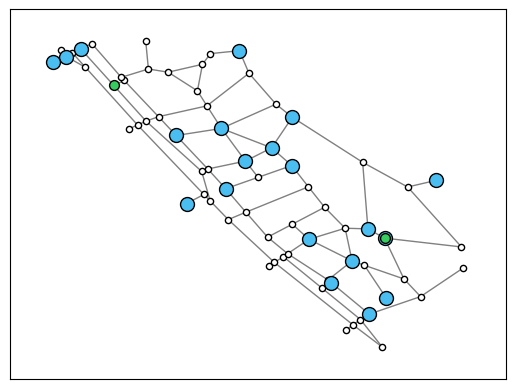

node: 10616940032
    - to: 11016298940, qVal: -1262.5866706546065
    - to: 11016696063, qVal: -1262.6287600476603
    - to: 11016298940, qVal: -1262.608634218975
    - to: 11016696063, qVal: -1262.5765676358772
node: 11016696064
    - to: 11016696062, qVal: -887.4687659407397
    - to: 11016696063, qVal: -887.4166197370209
    - to: 11016696062, qVal: -887.4371601120372
    - to: 11016696063, qVal: -887.4430096002128
    - to: 11016696065, qVal: -887.4539253987501
    - to: 11016696065, qVal: -887.4112570436705
node: 10616940034
    - to: 6297396119, qVal: -755.4166469612483
    - to: 11016696070, qVal: -755.3910923246021
    - to: 11016298967, qVal: -755.4000408762305
    - to: 11016696054, qVal: -755.3632973750828
    - to: 6297396119, qVal: -755.3538493167633
    - to: 11016298967, qVal: -755.3562095993348
    - to: 11016696054, qVal: -755.4507474734695
    - to: 11016696070, qVal: -755.4260102672447
node: 11016696065
    - to: 1494150098, qVal: -895.3822967573328
    - to: 110162

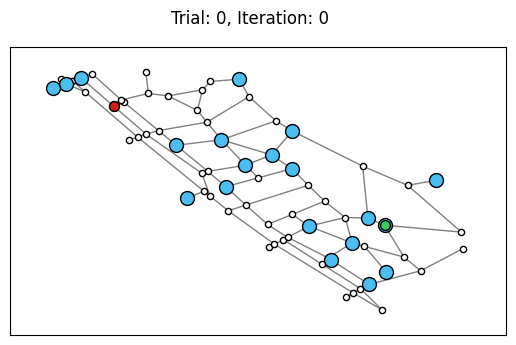

In [ ]:
map = genMap().returnMap()
map.plotGraph()

qlearn = QLearn(map)
qlearn.start()